In [69]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd

def extract_tb_data(log_dir):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # Get 'ep_rew_mean' data
    steps = []
    rewards = []
    for event in event_acc.Scalars('rollout/ep_rew_mean'):
        steps.append(event.step)
        rewards.append(event.value)

    return pd.DataFrame({'step': steps, 'rollout/ep_rew_mean': rewards})

# Paths to your TensorBoard logs
log_dirs = {
    'MLP': './MLP-50-5/',
    'Transformer': './Transformer-50-5/',
    'GNN': './GNN-50-5/',
    'GNN-Transformer': './GNN-Transformer-50-5/'
}
# event_acc = EventAccumulator('./MLP-100-10/')
# event_acc.Reload()

# # Print all available tags
# print(event_acc.Tags()['scalars'])

dataframes = {model: extract_tb_data(log_dir) for model, log_dir in log_dirs.items()}


In [70]:
combined_df = pd.concat([df.assign(Model=model) for model, df in dataframes.items()])


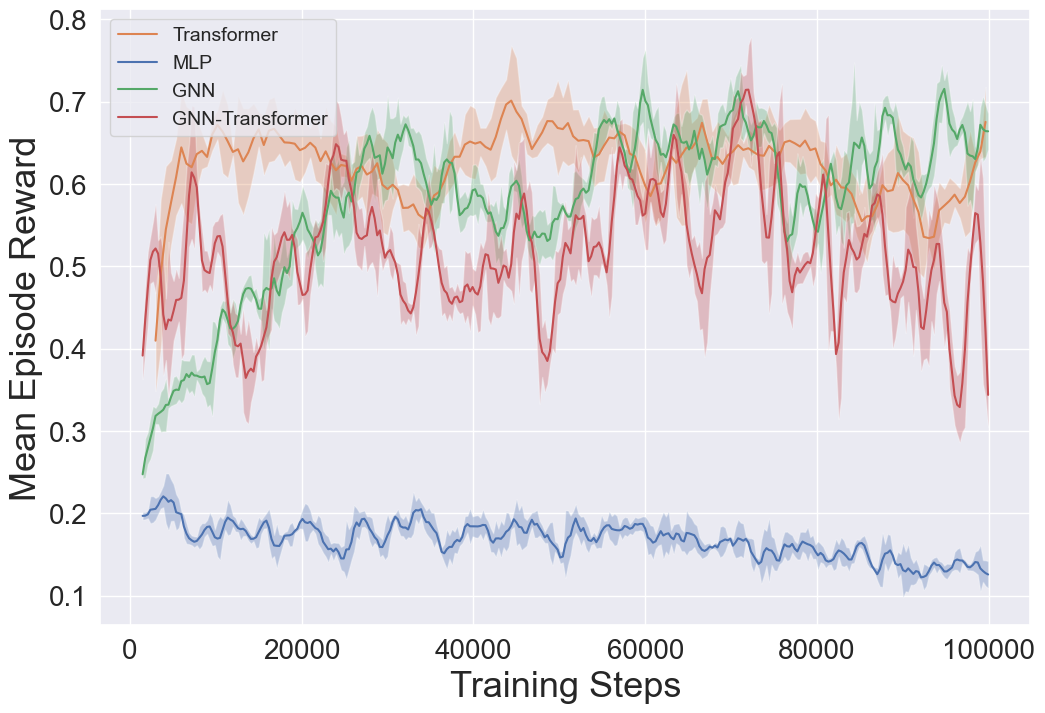

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and context to make the plot more "publication-ready"
sns.set_theme()

# Smoothing function
def smooth(data, window_size=1):
    return data.rolling(window=window_size).mean()

# Create the plot
plt.figure(figsize=(12, 8))

# Plot with smoothing and shaded area for standard deviation
for model in combined_df['Model'].unique():
    model_data = combined_df[combined_df['Model'] == model]

    # Apply smoothing to the mean rewards
    if model == "Transformer":
        smoothed_rewards = smooth(model_data['rollout/ep_rew_mean'], window_size=5)
    elif model == "GNN":
        smoothed_rewards = smooth(model_data['rollout/ep_rew_mean'], window_size=5)
    else:
        smoothed_rewards = smooth(model_data['rollout/ep_rew_mean'], window_size=5)

    # Plot the smoothed line
    label = f'{model}' if model == "Transformer" else model
    sns.lineplot(x=model_data['step'], y=smoothed_rewards, label=label)

    # Plot the shaded area for standard deviation
    std_dev = model_data['rollout/ep_rew_mean'].rolling(window=3).std()
    plt.fill_between(model_data['step'], smoothed_rewards - std_dev, smoothed_rewards + std_dev, alpha=0.3)

# Add titles and labels
plt.xlabel('Training Steps')
plt.ylabel('Mean Episode Reward')

# Add titles and labels with increased font size
plt.xlabel('Training Steps', fontsize=26)
plt.ylabel('Mean Episode Reward', fontsize=26)

# Increase the font size of the tick labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Modify the legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index('Transformer')] + [i for i in range(len(labels)) if labels[i] != 'Transformer']
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=14)

plt.show()
